<a href="https://www.kaggle.com/code/nyagami/playground-series-concrete-strength-prediction?scriptVersionId=122057776" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
## About Dataset
The dataset was generated from a deep learning model trained on the Concrete Strength Prediction dataset. 

# Import Libraries & Read Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression,SGDRegressor, Ridge
import xgboost as xgb
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv',index_col = 'id')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv',index_col = 'id')

# Preview files

In [3]:
train.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [4]:
y = train['Strength']
train.drop('Strength',axis=1, inplace = True)
y

id
0       10.38
1       23.52
2       36.96
3       39.05
4       74.19
        ...  
5402    15.42
5403    49.20
5404    39.30
5405    39.61
5406    63.14
Name: Strength, Length: 5407, dtype: float64

In [5]:
train.shape

(5407, 8)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5407 entries, 0 to 5406
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            5407 non-null   float64
 1   BlastFurnaceSlag           5407 non-null   float64
 2   FlyAshComponent            5407 non-null   float64
 3   WaterComponent             5407 non-null   float64
 4   SuperplasticizerComponent  5407 non-null   float64
 5   CoarseAggregateComponent   5407 non-null   float64
 6   FineAggregateComponent     5407 non-null   float64
 7   AgeInDays                  5407 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 380.2 KB


# Preprocessing of Data
## Checking for correlation of variables
The pairplot shows the relationship between the variables in the dataset. There doesn't seem to be any strong correlation between variables, which is good for models.

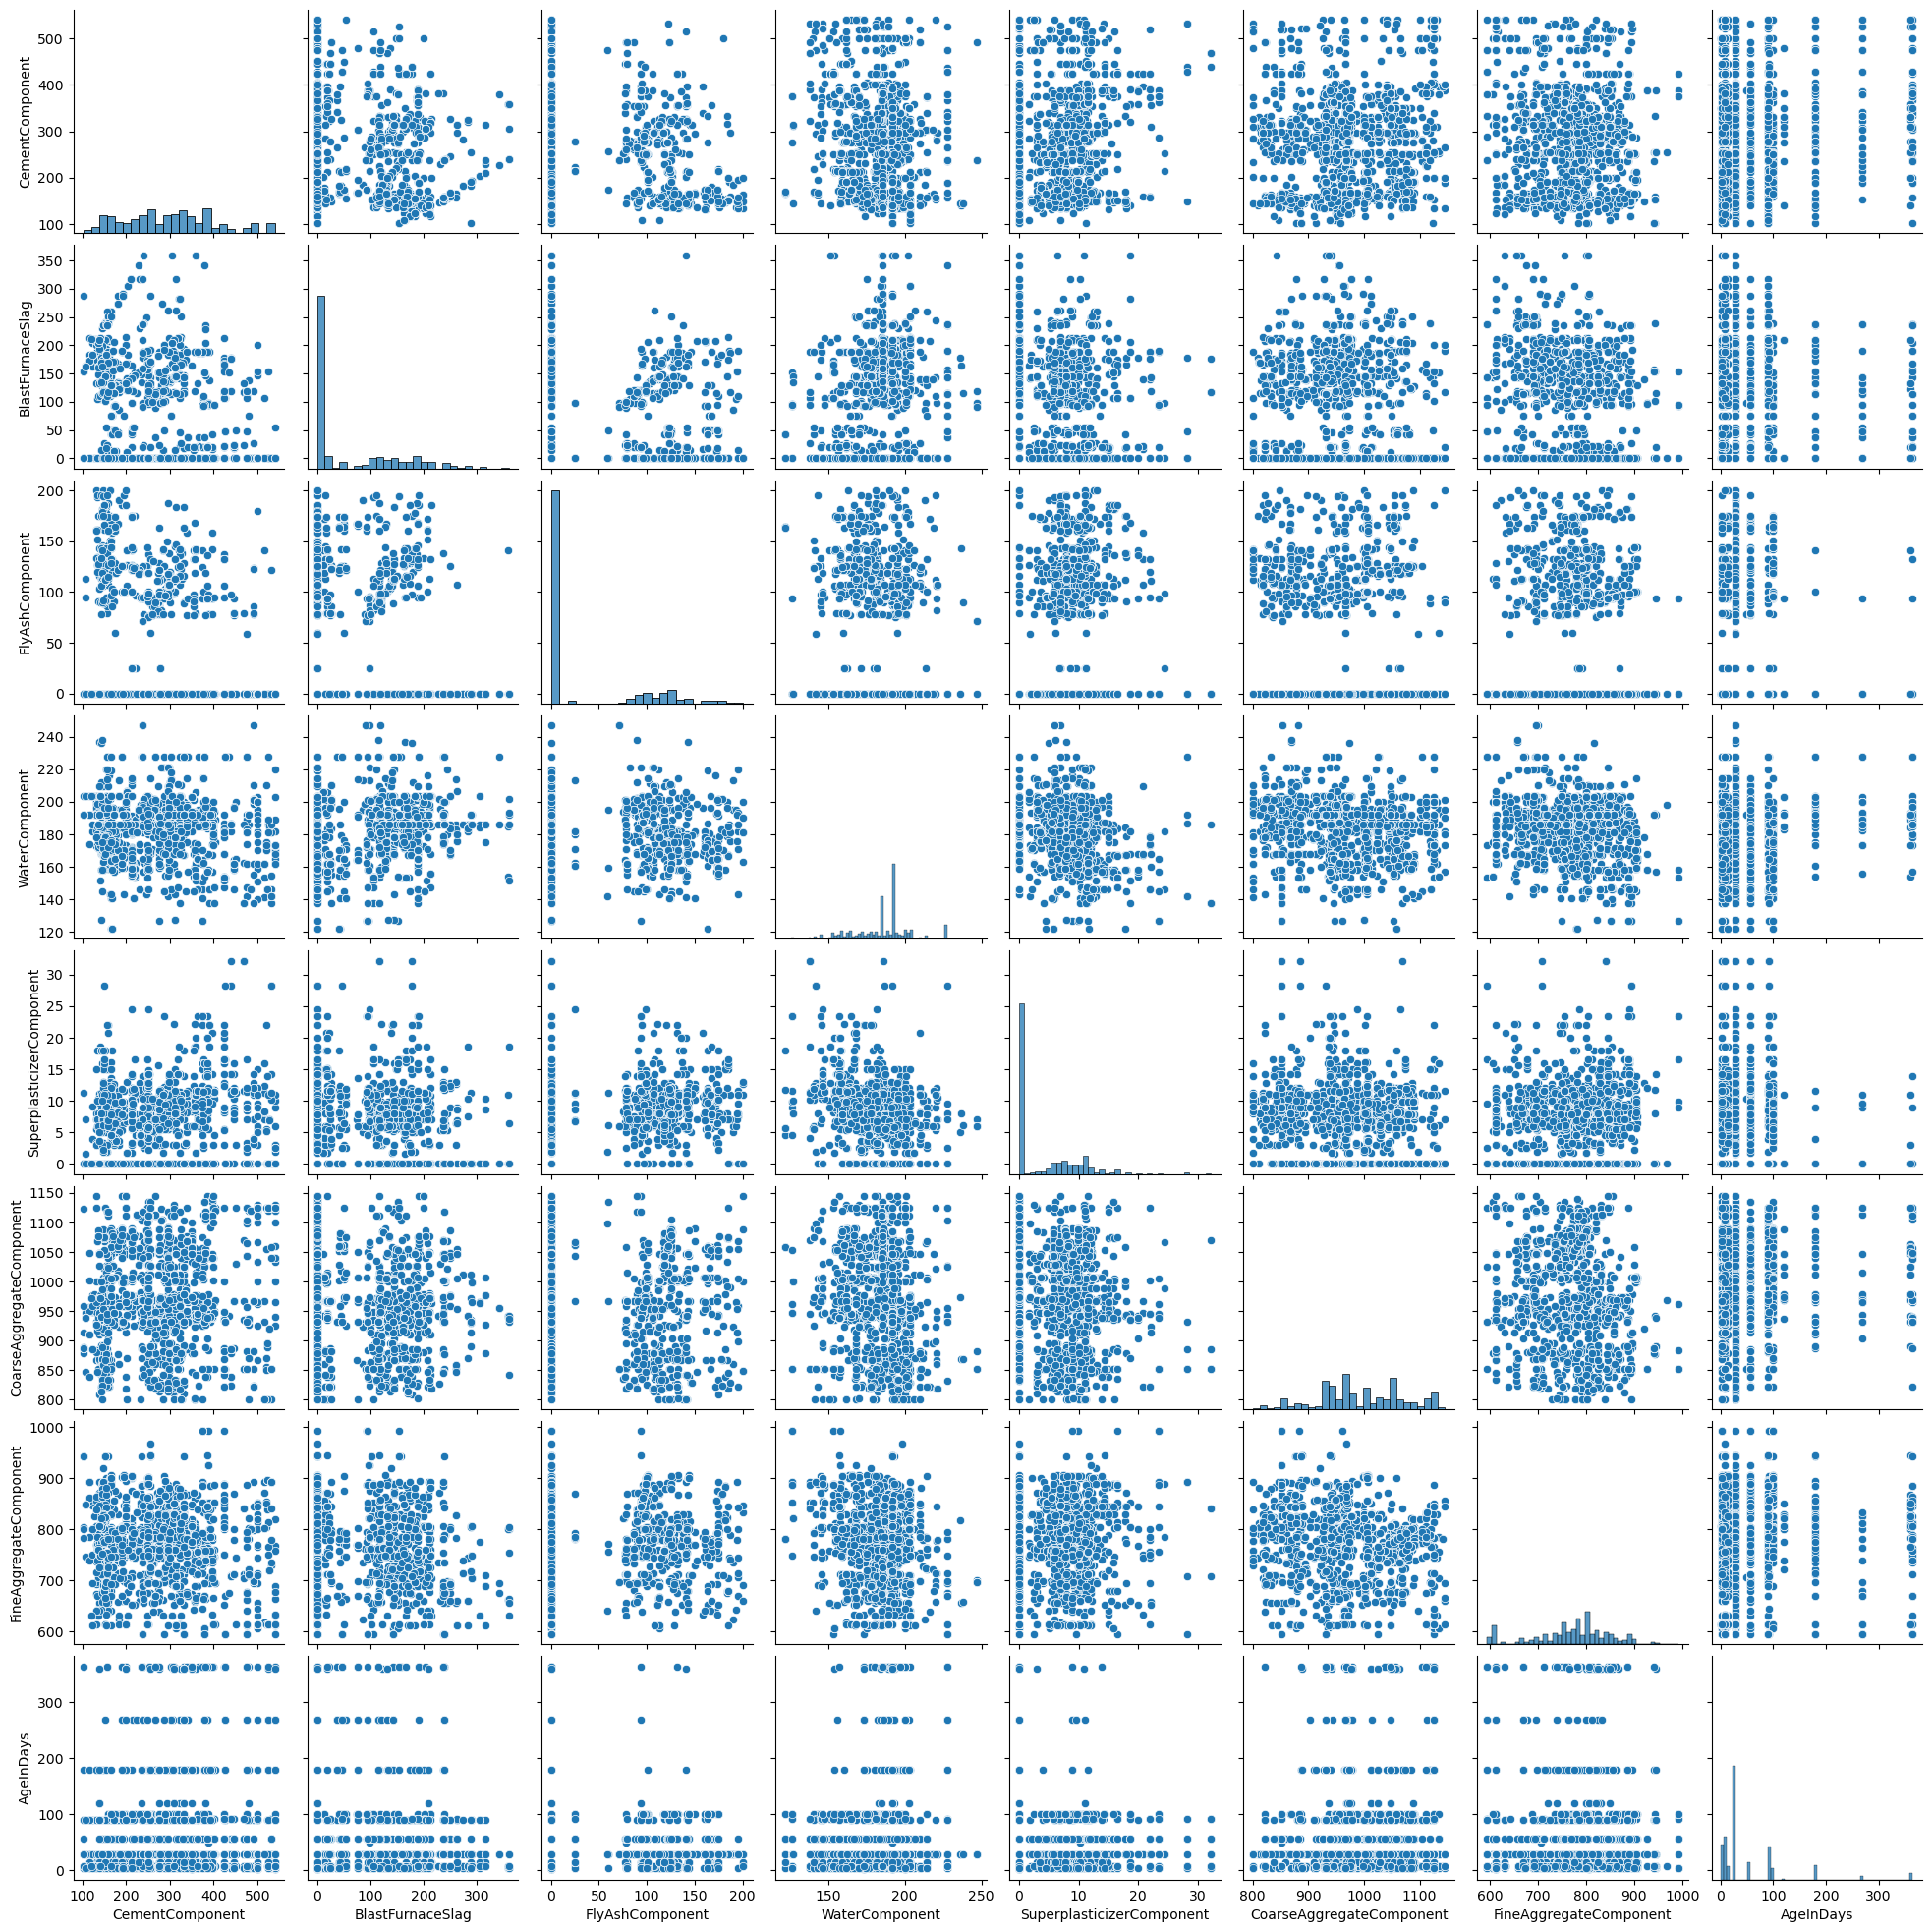

In [7]:
sns.pairplot(train)
plt.show()

## Missing values
The dataset has no missing values in both the train and test sets.

In [8]:
train.isna().sum()

CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
dtype: int64

## Outliers
The boxplot highlights two key points:
- There are outliers in the dataset, and these could create bias in our models. These will be removed.
- The variables have different variances, and will therefore require standardization before modeling. 

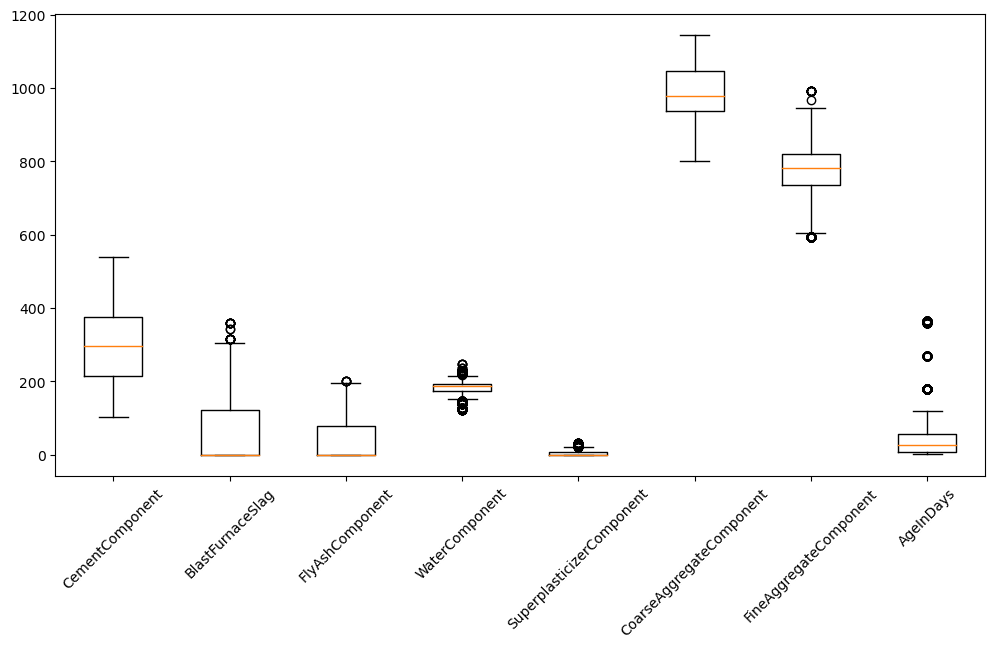

In [9]:
fig = plt.figure(figsize = (12,6))
plt.boxplot(train)
plt.xticks([1,2,3,4,5,6,7,8],train.columns, rotation = 45)
plt.show()

In [10]:
### Removing outliers using IQR method
#Outliers affect statistics such as mean, since they are extreme values that can shift the mean in one direction. One of the most reliable way of removing outliers is by using the interquartile range. Outliers are values below `Q1 − 1.5 × IQR` or above `Q3 + 1.5 × IQR`. Here, they will be replaced with nan values before being removed

In [11]:
# for col in train.columns:
#     # Compute Q1, Q3, and IQR
#     Q3 = np.quantile(train[col],0.75)
#     Q1 = np.quantile(train[col],0.25)
#     IQR = Q3 - Q1
    
#     # Set the limits
#     upper_limit = Q3 + IQR*1.5
#     lower_limit = Q1 - IQR*1.5

#     # Replace outliers with nan values
#     train.loc[(train[col] > upper_limit) | (train[col] < lower_limit),[col]] = np.nan


In [12]:
#Watercomponent variable has majority of the outliers. There are several ways of dealing with outliers, but since our dataset is big enough, we can afford to drop rows with outliers. A total of 873 rows are dropped. 

In [13]:
#train.isna().sum()

### Removing outliers using standard deviation method
This method eliminates all data points further than 3 standard deviations from the mean.

In [14]:
for col in train.columns:
    mean = train[col].mean()
    std = train[col].std()
    cut_off = std * 3
    
    # Set the limits
    upper_limit = mean + cut_off
    lower_limit = mean - cut_off

    # Replace outliers with nan values
    train.loc[(train[col] > upper_limit) | (train[col] < lower_limit),[col]] = np.nan


In [15]:
train.isna().sum()

CementComponent                0
BlastFurnaceSlag              21
FlyAshComponent                5
WaterComponent                37
SuperplasticizerComponent     72
CoarseAggregateComponent       0
FineAggregateComponent         0
AgeInDays                    203
dtype: int64

In [16]:
print(train.shape)
train.dropna(how = 'any', inplace =True)
y = y.loc[train.index]
print(train.shape)

(5407, 8)
(5084, 8)


## Standardization of data

In [17]:
scaler = StandardScaler()

In [18]:
# Fit and transform the training set
train[train.columns] = scaler.fit_transform(train)

# Transform the test set
test[train.columns] = scaler.transform(test)

# Feature selection
We will evaluate whether dropping features reduces noise and improves our model.

## Feature selection with random forests
Dropping features does not improve our model by reducing its RMSE, therefore feature selection cannot be done.

In [19]:
for i in [8,7,6,5,4,3,2,1]:
    rfe_rf = RFE(estimator = RandomForestRegressor(), n_features_to_select = i)
    rfe_rf.fit(train, y)
    kf = KFold(n_splits = 6, shuffle = True, random_state = 90)
    scores = cross_val_score(rfe_rf, train, y, cv = kf, scoring = 'neg_mean_squared_error')
    print(f'{i} features = {np.mean(np.sqrt(np.abs(scores)))} RMSE')

8 features = 12.832157634310333 RMSE
7 features = 12.792592899292641 RMSE
6 features = 12.858264149422892 RMSE
5 features = 12.912373899272422 RMSE
4 features = 13.119222627716459 RMSE
3 features = 13.16301270958447 RMSE
2 features = 13.013657550990123 RMSE
1 features = 12.769889321930862 RMSE


## Feature selection with xgboost
Feature selection with xgboost does not bear fruit since there is no reduction in RMSE of the model.

In [20]:
for i in [8,7,6,5,4,3,2,1]:
    rfe_xgb = RFE(estimator = xgb.XGBRegressor(), n_features_to_select = i)
    rfe_xgb.fit(train, y)
    kf = KFold(n_splits = 6, shuffle = True, random_state = 90)
    scores = cross_val_score(rfe_xgb, train, y, cv = kf, scoring = 'neg_mean_squared_error')
    print(f'{i} features = {np.mean(np.sqrt(np.abs(scores)))} RMSE')

8 features = 12.899194920064547 RMSE
7 features = 12.886060861673071 RMSE
6 features = 12.848598318330184 RMSE
5 features = 13.001480301990059 RMSE
4 features = 12.947112116963737 RMSE
3 features = 13.00364180132494 RMSE
2 features = 12.729717681916922 RMSE
1 features = 12.771778480800249 RMSE


## Feature selection with Lasso
Lasso does not show promising results in feature selection and reduction in RMSE. 

In [21]:
for i in [8,7,6,5,4,3,2,1]:
    rfe_las = RFE(estimator = Lasso(alpha =0.00548), n_features_to_select = i)
    rfe_las.fit(train, y)
    kf = KFold(n_splits = 6, shuffle = True, random_state = 90)
    scores = cross_val_score(rfe_las, train, y, cv = kf, scoring = 'neg_mean_squared_error')
    print(f'{i} features = {np.mean(np.sqrt(np.abs(scores)))} RMSE')

8 features = 14.036035123106004 RMSE
7 features = 14.039294499092676 RMSE
6 features = 14.038724029673537 RMSE
5 features = 14.03803071621177 RMSE
4 features = 14.059571023171335 RMSE
3 features = 14.172956495699166 RMSE
2 features = 14.32283385873672 RMSE
1 features = 14.96513638480291 RMSE


# Model evaluation
We evaluate different models and select the best performing for hyperparameter tuning.

In [22]:
estimators = [('bagging',BaggingRegressor()), ('adaboost',AdaBoostRegressor()),('decision_tree',DecisionTreeRegressor()),('linear',LinearRegression()),
              ('svr',SVR()),('randomforest',RandomForestRegressor()),('xgboost',xgb.XGBRegressor()),('lasso',Lasso()),('sgd',SGDRegressor()),
              ('ridge',Ridge()),('svr_l',LinearSVR()),('gradientb',GradientBoostingRegressor())]
rmse_list =[]

for clf_name, clf in estimators:    
    clf.fit(train, y)
    kf = KFold(n_splits = 6, shuffle = True, random_state = 90)
    scores = cross_val_score(clf, train, y, cv = kf, scoring = 'neg_mean_squared_error')
    rmse = np.mean(np.sqrt(np.abs(scores)))
    rmse_list.append({'rmse':rmse, 'regressor':clf_name})

In [23]:
rmse_df = pd.DataFrame(rmse_list).set_index('regressor')
rmse_df.sort_values(by='rmse')

,rmse
regressor,
gradientb,12.112921
adaboost,12.785772
randomforest,12.812899
xgboost,12.899195
svr,12.976938
bagging,13.073208
ridge,14.036038
linear,14.036051
sgd,14.041154


# Testing the ensemble

In [24]:
estimators = [('svr',SVR()),('xgboost',xgb.XGBRegressor()),('randomforest',RandomForestRegressor()),
              ('adaboost',AdaBoostRegressor()),('gradientb',GradientBoostingRegressor())]

vr = VotingRegressor(estimators = estimators)
vr.fit(train,y)
kf = KFold(n_splits = 6, shuffle = True, random_state = 90)
scores = cross_val_score(vr, train, y, cv = kf, scoring = 'neg_mean_squared_error')
rmse = np.mean(np.sqrt(np.abs(scores)))
print(f'{rmse:,.4f}')

12.1546


# Hyperparameter Tuning
## xgboost

In [25]:
# Instantiate model
xgb_reg = xgb.XGBRegressor()

# Instantiate a KFold object
kf = KFold(n_splits =6, shuffle = True, random_state = 90)

# Create your parameters
param_grid = {
    'n_estimators':[12],'max_depth':[3],'learning_rate':[0.35],'reg_alpha':[10],'reg_lambda':[7], 
    'objective':['reg:squarederror']
}
# Perform cross validation
xgb_cv = GridSearchCV(estimator = xgb_reg, param_grid = param_grid, cv = kf, scoring = 'neg_mean_squared_error', verbose =1)

# Fit model 
xgb_cv.fit(train,y)

# Evaluate model
rmse = np.sqrt(np.abs(xgb_cv.best_score_))
print(f'Best score {rmse:,.4}')
print(f'Best params {xgb_cv.best_params_}')

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Best score 12.1
Best params {'learning_rate': 0.35, 'max_depth': 3, 'n_estimators': 12, 'objective': 'reg:squarederror', 'reg_alpha': 10, 'reg_lambda': 7}


In [26]:
xgb_reg = xgb_cv.best_estimator_

## Support Vector Regressor

In [27]:
# Instantiate model
svr = SVR()

# Instantiate a KFold object
kf = KFold(n_splits =6, shuffle = True, random_state = 90)

# Create your parameters
param_grid = {
    'gamma':[0.2], 'C':[10], 'epsilon':[5]
}
# Perform cross validation
svr_cv = GridSearchCV(estimator = svr, param_grid = param_grid, cv = kf, scoring = 'neg_mean_squared_error', verbose =1)

# Fit model 
svr_cv.fit(train,y)

# Evaluate model
rmse = np.sqrt(np.abs(svr_cv.best_score_))
print(f'Best score {rmse:,.4}')
print(f'Best params {svr_cv.best_params_}')

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Best score 12.4
Best params {'C': 10, 'epsilon': 5, 'gamma': 0.2}


In [28]:
svr_reg = svr_cv.best_estimator_

## Random Forest

In [29]:
# Instantiate model
random_f = RandomForestRegressor()

# Instantiate a KFold object
kf = KFold(n_splits =6, shuffle = True, random_state = 90)

# Create your parameters
param_grid = {
    'n_estimators':[200], 'max_depth':[6], 'min_samples_leaf':[7]
}
# Perform cross validation
random_f_cv = GridSearchCV(estimator = random_f, param_grid = param_grid, cv = kf, scoring = 'neg_mean_squared_error', verbose =1)

# Fit model 
random_f_cv.fit(train,y)

# Evaluate model
rmse = np.sqrt(np.abs(random_f_cv.best_score_))
print(f'Best score {rmse:,.4}')
print(f'Best params {random_f_cv.best_params_}')

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Best score 12.15
Best params {'max_depth': 6, 'min_samples_leaf': 7, 'n_estimators': 200}


In [30]:
r_forest_reg = random_f_cv.best_estimator_

## Gradient Boosting

In [31]:
# Instantiate model
gradient = GradientBoostingRegressor(random_state=90)

# Instantiate a KFold object
kf = KFold(n_splits =6, shuffle = True, random_state = 90)

# Create your parameters
param_grid = {
    'n_estimators':[170],'max_depth':[2], 'subsample':[0.5]
}
# Perform cross validation
gradient_cv = GridSearchCV(estimator = gradient, param_grid = param_grid, cv = kf, scoring = 'neg_mean_squared_error', verbose =1)

# Fit model 
gradient_cv.fit(train,y)

# Evaluate model
rmse = np.sqrt(np.abs(gradient_cv.best_score_))
print(f'Best score {rmse:,.4}')
print(f'Best params {gradient_cv.best_params_}')

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Best score 12.07
Best params {'max_depth': 2, 'n_estimators': 170, 'subsample': 0.5}


In [32]:
gradient_reg = gradient_cv.best_estimator_

## Adaboost

In [33]:
# Instantiate model
ada = AdaBoostRegressor(base_estimator = gradient_reg)

# Instantiate a KFold object
kf = KFold(n_splits =6, shuffle = True, random_state = 90)

# Create your parameters
param_grid = {
    'learning_rate':[0.01]
}
# Perform cross validation
ada_cv = GridSearchCV(estimator = ada, param_grid = param_grid, cv = kf, scoring = 'neg_mean_squared_error', verbose =1)

# Fit model 
ada_cv.fit(train,y)

# Evaluate model
rmse = np.sqrt(np.abs(ada_cv.best_score_))
print(f'Best score {rmse:,.4}')
print(f'Best params {ada_cv.best_params_}')

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Best score 12.06
Best params {'learning_rate': 0.01}


In [34]:
ada_reg = ada_cv.best_estimator_
ada_reg

AdaBoostRegressor(base_estimator=GradientBoostingRegressor(max_depth=2,
                                                           n_estimators=170,
                                                           random_state=90,
                                                           subsample=0.5),
                  learning_rate=0.01)

## Bagging Regressor

In [35]:

# Instantiate model
bag = BaggingRegressor()

# Instantiate a KFold object
kf = KFold(n_splits =6, shuffle = True, random_state = 90)

# Create your parameters
param_grid = {
    'base_estimator':[xgb_reg], 'n_estimators':[60]
}
# Perform cross validation
bag_cv = GridSearchCV(estimator = bag, param_grid = param_grid, cv = kf, scoring = 'neg_mean_squared_error')

# Fit model 
bag_cv.fit(train,y)

# Evaluate model
rmse = np.sqrt(np.abs(bag_cv.best_score_))
print(f'Best score {rmse:,.4}')
print(f'Best params {bag_cv.best_params_}')

Best score 12.09
Best params {'base_estimator': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.35, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=12, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=7, ...), 'n_estimators': 60}


In [36]:
bag_reg = bag_cv.best_estimator_

# Evaluating the ensemble

## Evaluating individual models

In [37]:
estimators = [('svr',svr_reg),('xgboost',xgb_reg),('randomforest',r_forest_reg), ('adaboost',ada_reg),('bagging',bag_reg),('gradient',gradient_reg)]
rmse_ls =[]

for clf_name, clf in estimators:    
    clf.fit(train, y)
    kf = KFold(n_splits = 6, shuffle = True, random_state = 90)
    scores = cross_val_score(clf, train, y, cv = kf, scoring = 'neg_mean_squared_error')
    rmse = np.mean(np.sqrt(np.abs(scores)))
    print(f'{rmse:,.4f} for {clf_name}')
    rmse_ls.append({'rmse':rmse, 'regressor':clf_name})

12.3977 for svr
12.0945 for xgboost
12.1509 for randomforest
12.0603 for adaboost
12.0910 for bagging
12.0711 for gradient


In [38]:
my_rmse = pd.DataFrame(rmse_ls).set_index('regressor')
my_rmse.sort_values(by='rmse')

,rmse
regressor,
adaboost,12.060254
gradient,12.071139
bagging,12.090975
xgboost,12.094490
randomforest,12.150889
svr,12.397689


## Creating an ensemble with the models with tuned hyperparameters

In [39]:
estimators = [('adaboost',ada_reg),('xgboost',xgb_reg),('gradient',gradient_reg)]
vr = VotingRegressor(estimators = estimators)
vr.fit(train,y)
kf = KFold(n_splits = 6, shuffle = True, random_state = 90)
scores = cross_val_score(vr, train, y, cv = kf, scoring = 'neg_mean_squared_error')
rmse = np.mean(np.sqrt(np.abs(scores)))
print(f'{rmse:,.4f}')

12.0471


In [40]:
strength = vr.predict(test)
strength

array([49.55846204, 19.82636721, 33.79349782, ..., 39.18543339,
       35.49587477, 20.04468019])

In [41]:
submission = pd.DataFrame(strength, index = test.index, columns = ['Strength']).reset_index()
submission.to_csv('/kaggle/working/submission.csv', index = False)